In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sqlite3
from glob import glob

import joblib
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from arch.univariate.base import ARCHModelResult
from arch import arch_model
from config import settings
from retrieve_data import SQLiteRepo, MT5_Data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
repo = SQLiteRepo(connection=connection)

print(f"repo type: {type(repo)}")
print(f"repo.connection type:{type(repo.connection)}")

repo type: <class 'retrieve_data.SQLiteRepo'>
repo.connection type:<class 'sqlite3.Connection'>


In [1]:
from model import GarchModel

ticker = "GBPUSD"
# Instantiate a `GarchModel`
df_ticker = GarchModel(ticker=ticker, repo=repo, use_new_data=False)

# Does `gm_ambuja` have the correct attributes?
assert df_ticker.ticker == "GBPUSD"
assert df_ticker.repo == repo
assert not df_ticker.use_new_data
assert df_ticker.model_directory == settings.model_directory

NameError: name 'repo' is not defined

In [6]:
dir(df_ticker)[-6:]

['load',
 'model_directory',
 'predict_volatility',
 'repo',
 'ticker',
 'use_new_data']

In [7]:
df_ticker.ticker

'GBPUSD'

In [8]:
df_ticker.use_new_data

False

In [12]:
ticker = "AUDUSD"
av = MT5_Data()
df_ticker = av.ticker_data(ticker=ticker)

print(f"{ticker} type: {type(df_ticker)}")
df_ticker.head()

df_ticker type: <class 'pandas.core.frame.DataFrame'>


,open,high,low,close,tick_volume
date,,,,,
1993-04-27,0.7201,0.7265,0.7130,0.7150,2191
1993-04-28,0.7144,0.7185,0.7103,0.7135,1551
1993-04-29,0.7143,0.7160,0.7095,0.7103,901
1993-04-30,0.7106,0.7126,0.7035,0.7075,1511
1993-05-03,0.7065,0.7078,0.7060,0.7078,231


In [15]:
sub_1 = df_ticker.loc["2021-12-06"].to_frame().T
sub_1

,open,high,low,close,tick_volume
2021-12-06,0.70005,0.70544,0.69975,0.70499,114178.0


In [16]:
sub_2 = connection.cursor().execute("PRAGMA database_list;").fetchall()[0][-1]
sub_2

'G:\\My Drive\\SisengAI\\AlgorithmicTrading\\code_rebuilding\\vectorizedBactesting\\Project_8\\cdf.db'

In [17]:
repo = SQLiteRepo(connection=connection)
response = repo.insert_table(table_name=ticker, records=df_ticker, if_exists="replace")
print(response)

{'transaction_successful': True, 'records_inserted': 8746}


In [20]:
# Get first five rows of `AUDUSD` table
sub_3 = pd.read_sql(sql="SELECT * FROM AUDUSD LIMIT 5", con=connection)
sub_3

,date,open,high,low,close,tick_volume
0,2023-02-24 00:00:00,0.68079,0.68236,0.67183,0.67239,71430
1,2023-02-23 00:00:00,0.68024,0.68414,0.67812,0.68071,61012
2,2023-02-22 00:00:00,0.68522,0.68646,0.67945,0.68019,73251
3,2023-02-21 00:00:00,0.69039,0.69196,0.68471,0.68519,75154
4,2023-02-20 00:00:00,0.68622,0.69203,0.68613,0.69038,39484


In [23]:
#ticker = "GBPAUD"
model = GarchModel(repo=repo, ticker=ticker, use_new_data=False)
model.calc_returns(n_observations=2_500)

y_ticker = model.data

print(f"y_mtnoy type: {type(y_ticker)}")
print(f"y_mtnoy shape: {y_ticker.shape}")
y_ticker.head()

y_mtnoy type: <class 'pandas.core.series.Series'>
y_mtnoy shape: (2500,)


date
2014-12-04   -0.228471
2014-12-05   -0.702487
2014-12-06   -0.285865
2014-12-08   -0.139729
2014-12-09    0.082025
Name: returns, dtype: float64

In [24]:
# Get data for 8 Feb 2023
sub_4 = float(y_ticker["2023-02-08"])
sub_4

-0.40525975425736993

In [25]:
y_ticker_daily_volatility = y_ticker.std()

print(f"{ticker}_daily_volatility type: {type(y_ticker_daily_volatility)}") 
print(f"{ticker} Daily Volatility: {y_ticker_daily_volatility}")

AUDUSD_daily_volatility type: <class 'float'>
AUDUSD Daily Volatility: 0.6020358381801787


In [28]:
y_ticker_annual_volatility = y_ticker_daily_volatility * np.sqrt(252)

print(f"{ticker}_annual_volatility type: {type(y_ticker_annual_volatility)}")
print(f"{ticker} Annual Volatility: {y_ticker_annual_volatility}")

AUDUSD_annual_volatility type: <class 'numpy.float64'>
AUDUSD Annual Volatility: 9.557022649038466


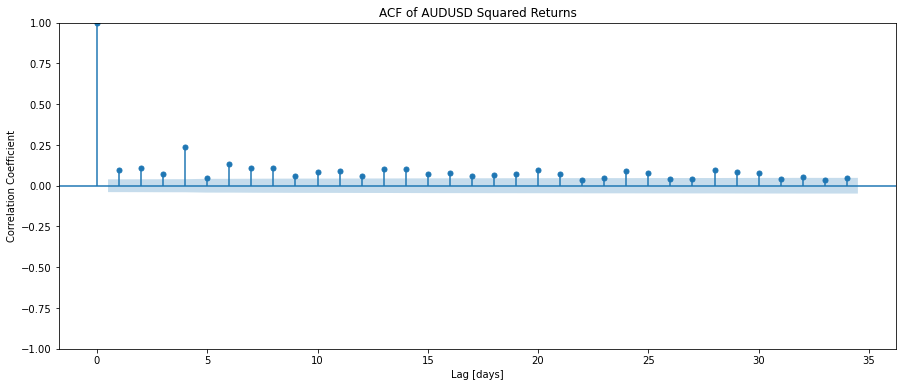

In [33]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_ticker**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")  
plt.ylabel("Correlation Coefficient")


# Add title
_=plt.title(f"ACF of {ticker} Squared Returns")

C:\Users\ricky\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


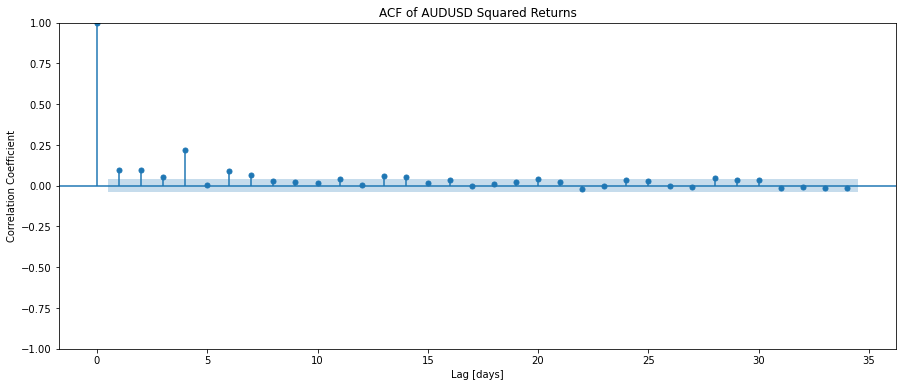

In [34]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_pacf(y_ticker**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")  
plt.ylabel("Correlation Coefficient")


# Add title
_=plt.title(f"ACF of {ticker} Squared Returns")

In [38]:
cutoff_test = int(len(y_ticker) * 0.8)
y_ticker_train =  (y_ticker.iloc[:cutoff_test]
                  .rename("returns")
                 )

print(f"{ticker}_train type: {type(y_ticker_train)}")
print(f"{ticker}_train shape: {y_ticker_train.shape}")
y_ticker_train.head()

AUDUSD_train type: <class 'pandas.core.series.Series'>
AUDUSD_train shape: (2000,)


date
2014-12-04   -0.228471
2014-12-05   -0.702487
2014-12-06   -0.285865
2014-12-08   -0.139729
2014-12-09    0.082025
Name: returns, dtype: float64

In [41]:
# Build and train model
model = arch_model(y_ticker, p=1, q=1, rescale=False).fit(disp=0)

print(f"model type: {type(model)}")

# Show model summary
model.summary() 

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2131.10
Distribution:                  Normal   AIC:                           4270.20
Method:            Maximum Likelihood   BIC:                           4293.50
                                        No. Observations:                 2500
Date:                Sat, Feb 25 2023   Df Residuals:                     2499
Time:                        09:58:13   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -8.1099e-03  1.065e-02     -0.762      0.446 [-2.897e-02,1.275e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.2415e-03  1.335e-03      1.680  9.304e-02 [-3.742e-04,4.857e-03]
alpha[1]       0.0310  8.541e-03      3.630  2.834e-04  [1.426e-02,4.774e-02]
beta[1]        0.9633  1.060e-02     90.836      0.000      [  0.942,  0.984]
=============================================================================

Covariance estimator: robust
"""

In [42]:
ticker = "EURAUD"
# Import `build_model` function
from main_module import build_model

# Build model using new `MTNOY` data
model = build_model(ticker=ticker, use_new_data=True)

# calc returns
model.calc_returns(n_observations=2500)

# Fit GARCH(1,1) model to data
model.fit(p=1, q=1)

# Does model have AIC and BIC attributes?
assert hasattr(model, "aic")
assert hasattr(model, "bic")

In [43]:
# Put test results into dictionary
sub_5 = {"has_aic": hasattr(model, "aic"), "has_bic": hasattr(model, "bic")}
sub_5

{'has_aic': True, 'has_bic': True}

In [44]:
# Import `FitIn` class and `fit_model` function
from main_module import FitIn, fit_model

# Instantiate `FitIn` object
request = FitIn(ticker=ticker, use_new_data=False, n_observations=2500, p=1, q=1)

# Build model and fit to data, following parameters in `request`
fit_out = fit_model(request=request)

# Inspect `fit_out`
fit_out

{'ticker': 'EURAUD',
 'use_new_data': False,
 'n_observations': 2500,
 'p': 1,
 'q': 1,
 'success': True,
 'message': "Trained and saved 'models\\EURAUD_2023-02-25T10.03.15.341879.pkl'. Metrics: AIC 3628.390721682199, BIC 3651.686905725624."}

In [45]:
# URL of `/fit` path
url = "http://localhost:8008/fit"
# Data to send to path
json = {
    "ticker": f"{ticker}",
    "use_new_data": False,
    "n_observations": 2500,
    "p": 1,
    "q": 1,
}
# Response of post request
response = requests.post(url=url, json=json)

print("response type:", type(response))
print("response status code:", response.status_code)

response type: <class 'requests.models.Response'>
response status code: 200


In [46]:
sub_6 = response.json()
sub_6

{'ticker': 'EURAUD',
 'use_new_data': False,
 'n_observations': 2500,
 'p': 1,
 'q': 1,
 'success': True,
 'message': "Trained and saved 'models\\EURAUD_2023-02-25T10.04.19.058387.pkl'. Metrics: AIC 3628.390721682199, BIC 3651.686905725624."}

In [47]:
# URL of `/predict` path
url = "http://localhost:8008/predict"
# Data to send to path
json = {"ticker": f"{ticker}", "n_days": 5}
# Response of post request
response = requests.post(url=url, json=json) 

print("response type:", type(response))
print("response status code:", response.status_code)

response type: <class 'requests.models.Response'>
response status code: 200


In [48]:
sub_7 = response.json()
sub_7

{'ticker': 'EURAUD',
 'n_days': 5,
 'success': True,
 'forecast': {'2023-02-13T00:00:00': 0.5457643230062942,
  '2023-02-14T00:00:00': 0.5457949880546636,
  '2023-02-15T00:00:00': 0.545825377412741,
  '2023-02-16T00:00:00': 0.5458554935743217,
  '2023-02-17T00:00:00': 0.5458853390103688},
 'message': ''}